## Exploratory Analysis

We will perform in this notebook an exploratory analysis of our data. Let's start with the English dataset.

In [8]:
%load_ext autoreload
%autoreload 2
import pandas as pd

full_df = pd.read_table("../data/English/task_a_distant.tsv", index_col=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
sum(full_df["average"] > 0.85)

120596

In [10]:
full_df.shape

(9075418, 3)

Citing the README

```
- AVG_CONF is the average of the confidences predicted by several supervised models for a specific instance to belong to the positive class for that subtask. The positive class is OFF for subtask A, and UNT for subtask B.

- CONF_STD is the confidences' standard deviation from AVG_CONF for a particular instance.
```

Let's take a sample because this dataset is huge

In [11]:
df = full_df.sample(frac=0.05)

In [12]:
pd.options.display.max_colwidth = 800
df[:2]

,text,average,std
id,,,
1160836963114659840,"@USER @USER Well, she would.....if you had any.",0.17682,0.180129
1159284844045750272,Be a lil nice to a nigga next thing you know he think he your boyfriendno cap.. niggas find out i only want them as my friend and stop talking to me 😭,0.72805,0.158456


Let's look for some instances with high average confidence for the models

In [13]:
df[df["average"] > 0.9][:3]

,text,average,std
id,,,
1188195306787221505,bitches be dating white boi’s talkin bout “with my nigga” bitch that’s Hitler 😳,0.910988,0.135106
1187976114121125888,@USER shut the fuck up applebees...,0.911388,0.095416
1158196421293723650,@USER Felt this shit in my soul,0.902224,0.134789


## Distribution of confidences

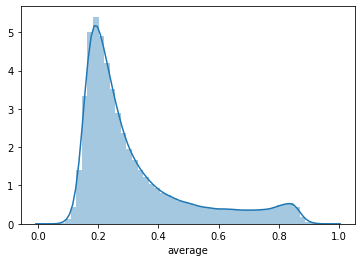

In [14]:
import seaborn as sns

sns.distplot(df["average"]);

What about the stds?

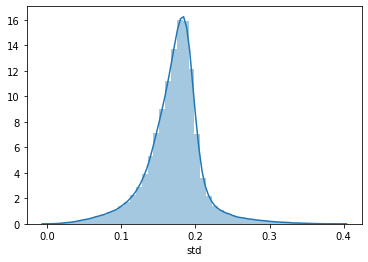

In [15]:
sns.distplot(df["std"])


Remember that given the mean $\mu$ and the std $\sigma$ (and asumming normality of the data) we have the predictions with a 0.68 confidence interval in $(\mu-\sigma, \mu+\sigma)$, and a 0.95 if two sigma are taken.

A simple approach I think would be to do the following:

- First, keep just the tweets with $\sigma \leq \epsilon$ ($\epsilon$ could be, 0.15)
- Label as offensive those with $\mu > (0.5 + \epsilon)$, so you got at least a 0.68 confidence interval that the mean is above 0.5
- Label as not offensive those with $\mu < 0.5 - \epsilon$ for the same reason
- Discard the others

Another strategy would be to fit our models using real cross entropy loss. That is, instead of training against a binary label use `average` as target output. 

Some ideas:

- Means might not be calibrated
- Use low std examples
- Weight them?


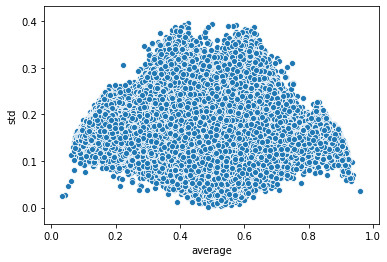

In [19]:
sns.scatterplot(x=df["average"], y=df["std"])

In [25]:
df["liminf"] = df["average"] -  df["std"]
df["limsup"] = df["average"] +  df["std"]

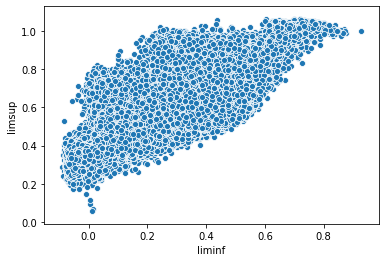

In [26]:
sns.scatterplot(x=df["liminf"], y=df["limsup"])

## OLID Dataset

This dataset will be used as development dataset

Copy-pasting some of the data in `data/olid/README.txt`:


1) DESCRIPTION

This is the README file for OLID described in: https://arxiv.org/abs/1902.09666

OLID contains 14,100 annotate tweets. It has been used as the official dataset for OffensEval: Identifying and Categorizing Offensive Language in Social Media (SemEval 2019 - Task 6): https://competitions.codalab.org/competitions/20011

The files included are: 

- olid-training-v1.tsv contains 13,240 annotated tweets. 
- olid-annotation.txt contains a short summary of the annotation guidelines.
- testset-levela.tsv contains the test set instances of level a.
- testset-levelb.tsv contains the test set instances of level b.
- testset-levelc.tsv contains the test set instances of level c.
- labels-levela.csv contains the gold labels and IDs of the instances in test set layer a.
- labels-levelb.csv contains the gold labels and IDs of the instances test set layer b.
- labels-levelc.csv contains the gold labels and IDs of the instances test set layer c.

The dataset was annotated using crowdsourcing. The gold labels were assigned taking the agreement of three annotators into consideration. No correction has been carried out on the crowdsourcing annotations. 

Twitter user mentions were substituted by @USER and URLs have been substitute by URL.

OLID is annotated using a hierarchical annotation. Each instance contains up to 3 labels each corresponding to one of the following levels:

- Level (or sub-task) A: Offensive language identification; 

- Level (or sub-task) B: Automatic categorization of offense types;

- Level (or sub-task) C: Offense target identification.	

In [21]:
df_olid = pd.read_table("../data/olid/olid-training-v1.0.tsv", index_col=0)

df_olid.sample(2)

,tweet,subtask_a,subtask_b,subtask_c
id,,,,
44561,@USER Laws not just for Conservatives or an unpopular group with the Media. Women have long failed other women and the Me Too is no more sincere than the Feminist movement was about Bill Clinton or Ted Kennedy.,NOT,NaN,NaN
35524,Was this a threat from @USER #DangerousDemocrats #maga URL,OFF,TIN,OTH


Why is a tweet considered offensive? 

The annotation guidelines are not quite explicit...

```

*Rules & Tips*
Please rate the tweet according to whether it is offensive generally or to the target, not whether you are personally offended by it.
```


In [31]:
print(f"There are {df_olid.shape[0]} instances\n\nClass balance:")
df_olid["subtask_a"].value_counts(normalize=True)

There are 13240 instances

Class balance:


NOT    0.667674
OFF    0.332326
Name: subtask_a, dtype: float64

## Other languages

In [82]:
read_args = {
    "index_col": 0,
    "keep_default_na": False,
}
dfs = {
    "arabic": pd.read_table("../data/Arabic/offenseval-ar-training-v1.tsv", **read_args),
    "arabic-dev": pd.read_table("../data/Arabic/offenseval-ar-dev-v1.tsv", **read_args),
    "danish": pd.read_table("../data/Danish/offenseval-da-training-v1.tsv", **read_args),
    "greek":  pd.read_table("../data/Greek/offenseval-greek-training-v1.tsv", **read_args),
    "turkish": pd.read_table("../data/Turkish/offenseval-tr-training-v1.tsv", **read_args) 
}


for lang, df_lang in dfs.items():
    print("="*80, "\n")
    print(f"There are {df_lang.shape[0]} instances for {lang}")
    print(f"Columns = {df_lang.columns}\n")
    
    print("Class balance")
    print(df_lang["subtask_a"].value_counts(normalize=True), "\n")
    
    print("Example tweets")
    print(df_lang.sample(2)["tweet"])


There are 6839 instances for arabic
Columns = Index(['tweet', 'subtask_a'], dtype='object')

Class balance
NOT    0.799532
OFF    0.200468
Name: subtask_a, dtype: float64 

Example tweets
id
5303    @USER يا خوخا يا سكر كل سنة و انتي طيبة و السنين كلها فرحانة دايما و محققة لللي نفسك فيه و وسط اللي بتحبيهم😍💝💝💝
6219                                                                                    حبيبي يا حب عمري يا عمر حبي 💕💕💕
Name: tweet, dtype: object

There are 1000 instances for arabic-dev
Columns = Index(['tweet', 'subtask_a'], dtype='object')

Class balance
NOT    0.821
OFF    0.179
Name: subtask_a, dtype: float64 

Example tweets
id
7119      RT @USER: كَنيتها بين الحَنايا يا مَلاذ المستجير<LF>يا عالمٍ تَعلم خَفايا نفوسنا واللي حوّت<LF>وأنا الفَقير اللي يحب يشوف في وَجه الفَقي…
7544    @USER يا رب يا رب يا رب اللهم أمين يا أكرم الأكرمين يا أرحم الراحمين يا رب العالمين يا الله يا الله يا الله يا الله يا الله يا الله يا الله
Name: tweet, dtype: object

There are 2961 instances fo

## Truncated tweets

In [84]:
possibly_truncated = {}

for lang, df_lang in dfs.items():
    print(lang)
    possibly_truncated[lang] = []
    
    for t in df_lang["tweet"]:
        if t[-3:] == "URL":
            possibly_truncated[lang].append(t)
            
    print(f"There are {len(possibly_truncated[lang])} possibly truncated tweets for {lang}")

arabic
There are 1192 possibly truncated tweets for arabic
arabic-dev
There are 179 possibly truncated tweets for arabic-dev
danish
There are 161 possibly truncated tweets for danish
greek
There are 0 possibly truncated tweets for greek
turkish
There are 0 possibly truncated tweets for turkish


In [86]:
possibly_truncated["danish"][:10]

['>Havet var vredt den dag....   [Jeg forstod den reference....](URL',
 '[Her er mit indskud](URL',
 'My god! Feel your pain too min gut. Har de her to sataner og de skider i et væk. Især den grå. Den sorte har det noget nasty langt hår ved exit og har gentagne gange måtte køre Rodalon over gulvet efter hun har taget en røvtur over hele stuegulvet for at komme af med sit tilbageblevne halløj hun stadig har siddende i bagpelsen. Go ferie! URL',
 'Hvorfor vælge så kedeligt et billede, når Jylland er et af de smukkeste områder i Danmark? OP har sikkert aldrig været der, så her er et par forslag.  [Rubjerg Knude](URLøerne](URL',
 '[NEJ! så här tillverkar man el!](URL',
 '[[tungere vejtrækning](URL',
 'Ja ja vi ses på havet! URL',
 '[Blåv maj væsel, bææætsj!](URL',
 '[He he he...](URL',
 'Ikke alle er lige tilfredse med joken - dagens user report: [Imgur](URL']